# pyLemur Walkthrough

The goal of `pyLemur` is to simplify the analysis of multi-condition single-cell data. If you have collected a single-cell RNA-seq dataset with more than one condition, LEMUR predicts for each cell and gene how much the expression would change if the cell had been in the other condition.

`pyLemur` is a Python implementation of the LEMUR model; there is also an `R` package called [lemur](https://bioconductor.org/packages/lemur/), which provides additional functionality: identifying neighborhoods of cells that show consistent differential expression values and a pseudo-bulk test to validate the findings.

`pyLemur` implements a novel framework to disentangle the effects of known covariates, latent cell states, and their interactions. At the core is a combination of matrix factorization and regression analysis implemented as geodesic regression on Grassmann manifolds. We call this latent embedding multivariate regression (LEMUR). For more details, see our [preprint](https://www.biorxiv.org/content/10.1101/2023.03.06.531268).

## Data

For demonstration, I will use a dataset of interferon-$\beta$ stimulated blood cells from [kang2018](http://www.nature.com/articles/nbt.4042).

pyLemurの目的は、複数条件のシングルセルデータの解析を簡素化することです。複数の条件を持つシングルセルRNA-seqデータセットを収集した場合、LEMURは各細胞と遺伝子について、もしその細胞が他の条件にあったら発現がどれだけ変化するかを予測します。

pyLemurはLEMURモデルをPythonで実装したもので、lemurというRパッケージもあり、一貫した差分発現値を示す細胞の近傍領域の同定や、所見を検証するための擬似バルクテストといった追加機能を提供している。

pyLemurは、既知の共変量、潜在的な細胞の状態、それらの相互作用の影響を分離する新しいフレームワークを実装しています。その中核は、グラスマン多様体上の測地線回帰として実装された行列分解と回帰分析の組み合わせです。我々はこれを潜在埋め込み多変量回帰（LEMUR）と呼ぶ。詳細はプレプリントを参照。

デモのために、kang2018のインターフェロン刺激血球のデータセットを使う。
刺激された血液細胞のデータセットを使う。

In [1]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [2]:
# Standard imports
import numpy as np

In [3]:
import scanpy as sc

In [4]:
# pertpy is needed to download the Kang data
import pertpy

In [5]:
# This will download the data to ./data/kang_2018.h5ad
adata = pertpy.data.kang_2018()

In [6]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [7]:
adata.obs.head()

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12


In [8]:
adata.var.head()

,name
index,
AL627309.1,AL627309.1
RP11-206L10.2,RP11-206L10.2
RP11-206L10.9,RP11-206L10.9
FAM87B,FAM87B
LINC00115,LINC00115


In [9]:
# Store counts separately in the layers
adata.layers["counts"] = adata.X.copy()

The data consists of $24\,673$ cells and $15\,706$ genes. The cells were measured in two conditions (`label="ctrl"` and `label="stim"`). The authors have annotated the cell type for each cell, which will be useful to analyze LEMUR's results; however, note that the cell type labels are not used (and not needed) to fit the LEMUR model.

データは24,673細胞と15,706遺伝子からなる。細胞は2つの条件（label="ctrl "とlabel="stim"）で測定された。これはLEMURの結果を分析するのに役立つだろう。しかし、LEMURモデルを適合させるのに、細胞タイプのラベルは使われていない（必要ない）ことに注意。

In [10]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [11]:
adata.obs.head()

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12


## Preprocessing

LEMUR expects that the input has been variance-stabilized. Here, I will use the log-transformation as a simple, yet effective approach.
In addition, I will only work on the $1\,000$ most variable genes to make the results easier to manage.

LEMUR は入力が分散安定化されていることを期待する。ここでは、簡単で効果的なアプローチとして対数変換を使うことにする。また、結果を管理しやすくするために、最も変動しやすい1,000遺伝子だけを扱うことにする。

In [12]:
# This follows the standard recommendation from scanpy
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)

In [13]:
sc.pp.log1p(adata)

In [14]:
adata.layers["logcounts"] = adata.X.copy()

In [15]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor="cell_ranger")

In [16]:
adata = adata[:, adata.var.highly_variable].copy()

In [17]:
adata

AnnData object with n_obs × n_vars = 24673 × 1000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'logcounts'

If we make a 2D plot of the data using UMAP, we see that the cell types separate by treatment status.

UMAPを使ってデータを2Dプロットしてみると、治療状態によって細胞タイプが分かれていることがわかる。

In [18]:
sc.tl.pca(adata)

In [19]:
sc.pp.neighbors(adata)

In [20]:
sc.tl.umap(adata)

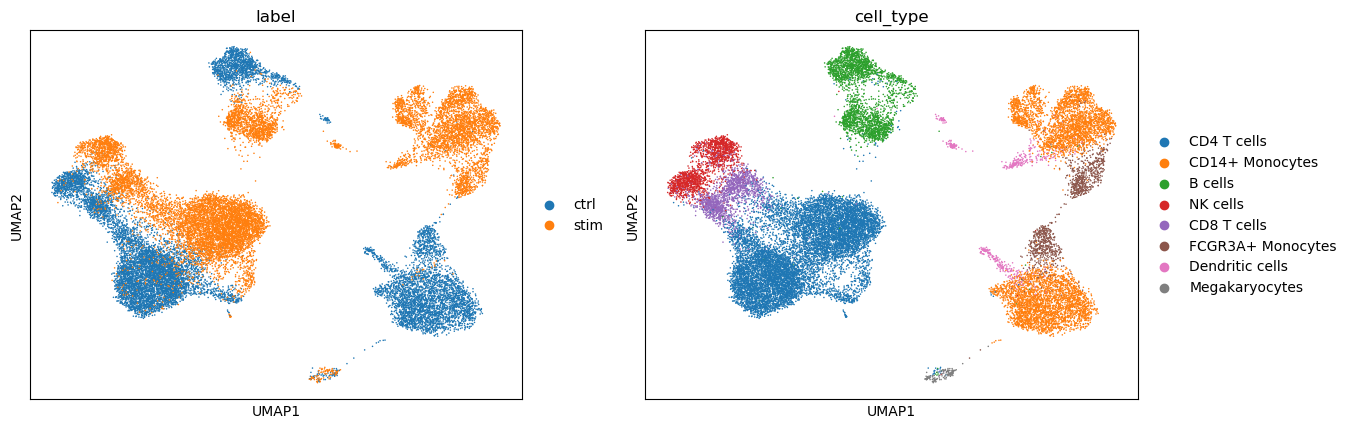

In [21]:
sc.pl.umap(adata, color=["label", "cell_type"])

## LEMUR

First, we import `pyLemur`; then, we fit the LEMUR model by providing the `AnnData` object, a specification of the experimental design, and the number of latent dimensions.

まず、pyLemurをインポートします。次に、AnnDataオブジェクト、実験計画の指定、潜在次元数を与えて、LEMURモデルを適合させます。

In [22]:
import pylemur

In [23]:
model = pylemur.tl.LEMUR(adata, design="~ label", n_embedding=15)

In [24]:
model.fit()

Centering the data using linear regression.
Find base point
Fit regression on latent spaces
Find shared embedding coordinates


In [25]:
model.align_with_harmony()

2024-08-10 17:51:01,423 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-10 17:51:03,502 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-10 17:51:03,665 - harmonypy - INFO - Stopped before convergence


Alignment iteration 0
Alignment iteration 1
Alignment iteration 2
Alignment iteration 3
Alignment iteration 4
Alignment iteration 5
Converged


In [26]:
model

To assess if the model was fit successfully, we plot a UMAP representation of the 15-dimensional embedding calculated by LEMUR. We want to see that the two conditions are well mixed in the embedding space because that means that LEMUR was able to disentangle the treatment effect from the cell type effect and that the residual variation is driven by the cell states.

モデルがうまくフィットしたかどうかを評価するために、LEMURが計算した15次元の埋め込みをUMAPでプロットする。これはLEMURが治療効果と細胞タイプ効果を分離できたことを意味し、残存変動が細胞状態によって駆動されていることを意味するからである。

In [27]:
# Recalculate the UMAP on the embedding calculated by LEMUR
adata.obsm["embedding"] = model.embedding

In [28]:
sc.pp.neighbors(adata, use_rep="embedding")

In [29]:
sc.tl.umap(adata)

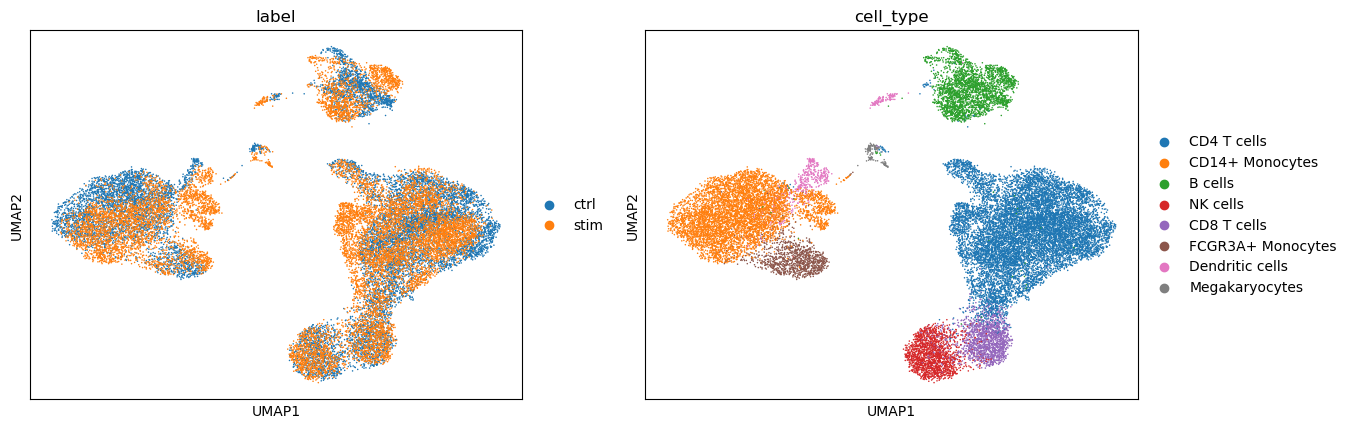

In [30]:
sc.pl.umap(adata, color=["label", "cell_type"])

The LEMUR model is fully parametric, which means that we can predict for each cell what its expression would have been in any condition (i.e., for a cell observed in the control condition, we can predict its expression under treatment) as a function of its low-dimensional embedding.

LEMURモデルは完全にパラメトリックであり、各細胞につい て、その低次元埋め込みの関数として、どのような条件下でどのような 発現があったかを予測できる（つまり、対照条件下で観察された細 胞について、治療下での発現を予測できる）。

In [31]:
# The model.cond(**kwargs) call specifies the condition for the prediction
ctrl_pred = model.predict(new_condition=model.cond(label="ctrl"))
stim_pred = model.predict(new_condition=model.cond(label="stim"))

In [32]:
ctrl_pred

array([[-4.46906538e-03, -3.10581033e-01,  8.26777406e-02, ...,
         1.57219192e-03,  2.78549859e-03, -1.27774419e-02],
       [ 1.77000096e-02,  1.94135718e-01,  6.73668353e-02, ...,
        -1.02429760e-03, -4.13575006e-03,  9.02863088e-03],
       [ 6.43811773e-02,  1.57288760e-02,  1.81702447e-02, ...,
         3.64405448e-05,  4.42724859e-03,  3.85129492e-02],
       ...,
       [ 3.06659722e-02,  1.09981254e+00,  4.33982146e-02, ...,
         7.37961597e-05,  1.36743170e-03,  6.88596108e-02],
       [-2.71146796e-02, -6.21991841e-01, -4.70764576e-02, ...,
         1.46143737e-03,  2.33968777e-03,  7.72983533e-02],
       [-1.50956994e-02, -1.23740793e+00, -6.44128836e-02, ...,
         9.07080289e-04,  3.61891264e-03,  2.40372325e-02]])

In [33]:
stim_pred

array([[ 1.14759657e+00,  5.99558087e+00,  1.22248569e-02, ...,
        -8.29964547e-05, -7.17423903e-17,  2.93974761e-03],
       [ 9.84180614e-01,  6.02332928e+00,  6.19508734e-02, ...,
         5.94086765e-04,  4.73157353e-16, -5.67481877e-03],
       [ 1.77036981e-01,  3.76045216e+00, -6.30715494e-03, ...,
         4.31180226e-03,  2.16649112e-16,  7.52387295e-03],
       ...,
       [ 3.54076157e-02,  4.00616069e+00, -1.86121527e-04, ...,
         1.57267338e-03,  2.55145184e-16,  3.03287814e-02],
       [-8.23031501e-02,  3.82922880e+00, -1.84059794e-03, ...,
         5.08672495e-04,  3.06299717e-16,  4.79548057e-02],
       [-3.20097099e-02,  3.28217716e+00,  1.57156027e-02, ...,
         8.22016029e-04, -1.37513524e-17,  1.80953593e-02]])

We can now check the predicted differential expression against the underlying observed expression patterns for individual genes. Here, I chose _TSC22D3_ as an example. The blue cells in the first plot are in neighborhoods with higher expression in the control condition than in the stimulated condition. The two other plots show the underlying gene expression for the control and stimulated cells and confirm LEMUR's inference.

予測された差次的発現を、個々の遺伝子について観察された発現パターンと照らし合わせることができる。ここでは例としてTSC22D3を選んだ。最初のプロットの青い細胞は、刺激条件よりもコントロール条件の方が発現が高い近傍の細胞である。他の2つのプロットは、コントロールと刺激された細胞の基礎となる遺伝子発現を示し、LEMURの推論を確認している。

In [34]:
import matplotlib.pyplot as plt

In [35]:
adata.layers["diff"] = stim_pred - ctrl_pred

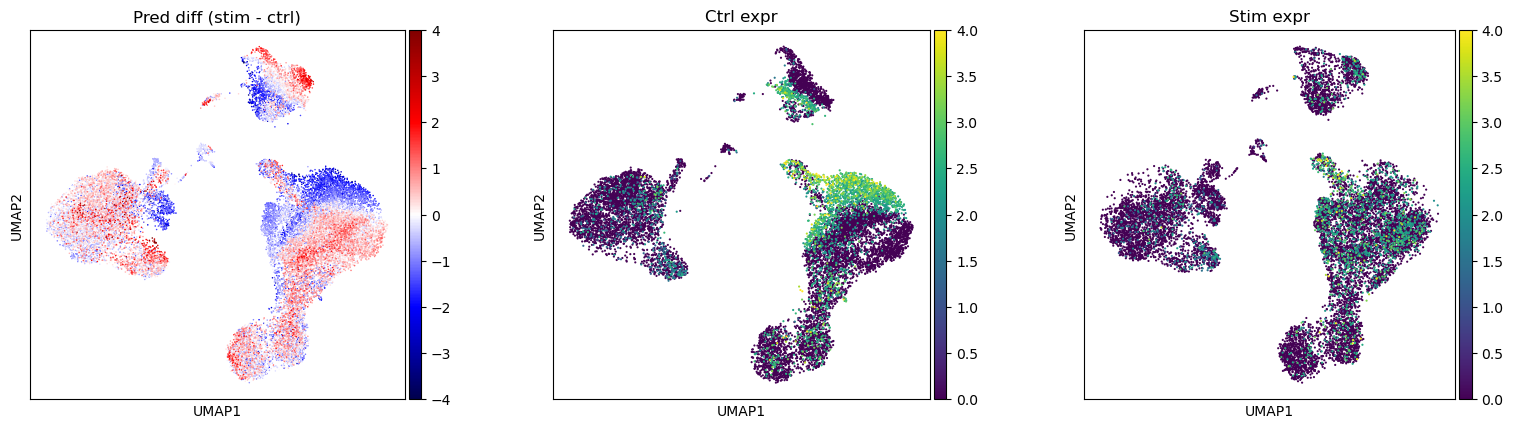

In [36]:
# Also try CXCL10, IL8, and FBXO40
sel_gene = "TSC22D3"

fsize = plt.rcParams['figure.figsize']

fig = plt.figure(figsize=(fsize[0] * 3, fsize[1]))

axs = [fig.add_subplot(1, 3, i+1) for i in range(3)]

for ax in axs:
    ax.set_aspect('equal')

sc.pl.umap(
    adata, layer="diff",
    color=[sel_gene], cmap=plt.get_cmap("seismic"), vcenter=0,
    vmin=-4, vmax=4,
    title="Pred diff (stim - ctrl)", ax=axs[0], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "ctrl"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=4,
    title="Ctrl expr", ax=axs[1], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "stim"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=4,
    title="Stim expr", ax=axs[2]
)

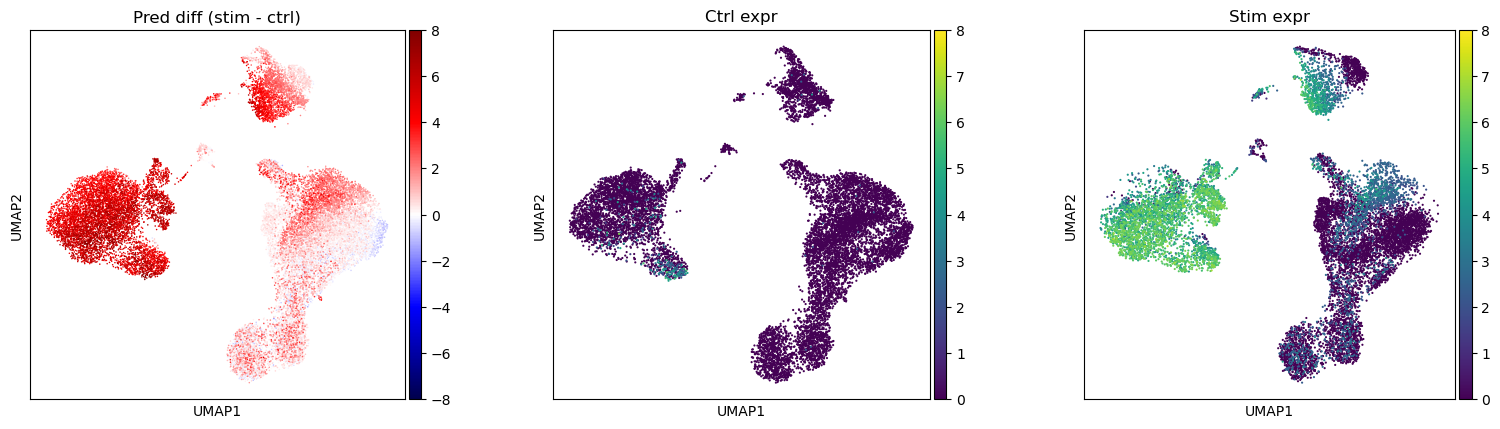

In [37]:
# Also try CXCL10, IL8, and FBXO40
sel_gene = "CXCL10"

fsize = plt.rcParams['figure.figsize']

fig = plt.figure(figsize=(fsize[0] * 3, fsize[1]))

axs = [fig.add_subplot(1, 3, i+1) for i in range(3)]

for ax in axs:
    ax.set_aspect('equal')

sc.pl.umap(
    adata, layer="diff",
    color=[sel_gene], cmap=plt.get_cmap("seismic"), vcenter=0,
    vmin=-8, vmax=8,
    title="Pred diff (stim - ctrl)", ax=axs[0], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "ctrl"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=8,
    title="Ctrl expr", ax=axs[1], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "stim"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=8,
    title="Stim expr", ax=axs[2]
)

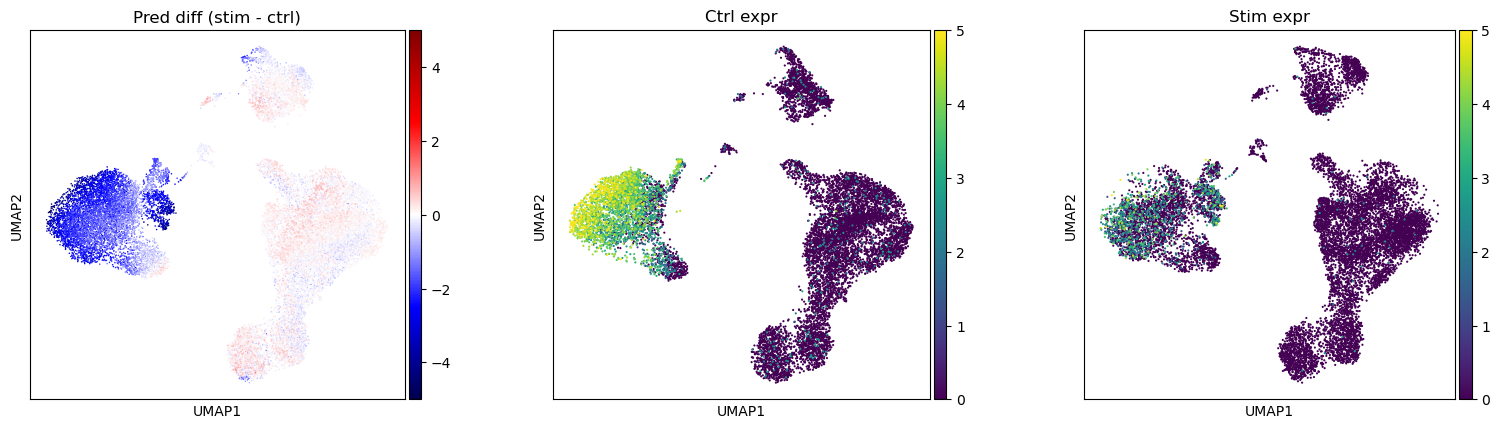

In [38]:
# Also try CXCL10, IL8, and FBXO40
sel_gene = "IL8"

fsize = plt.rcParams['figure.figsize']

fig = plt.figure(figsize=(fsize[0] * 3, fsize[1]))

axs = [fig.add_subplot(1, 3, i+1) for i in range(3)]

for ax in axs:
    ax.set_aspect('equal')

sc.pl.umap(
    adata, layer="diff",
    color=[sel_gene], cmap=plt.get_cmap("seismic"), vcenter=0,
    vmin=-5, vmax=5,
    title="Pred diff (stim - ctrl)", ax=axs[0], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "ctrl"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=5,
    title="Ctrl expr", ax=axs[1], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "stim"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=5,
    title="Stim expr", ax=axs[2]
)

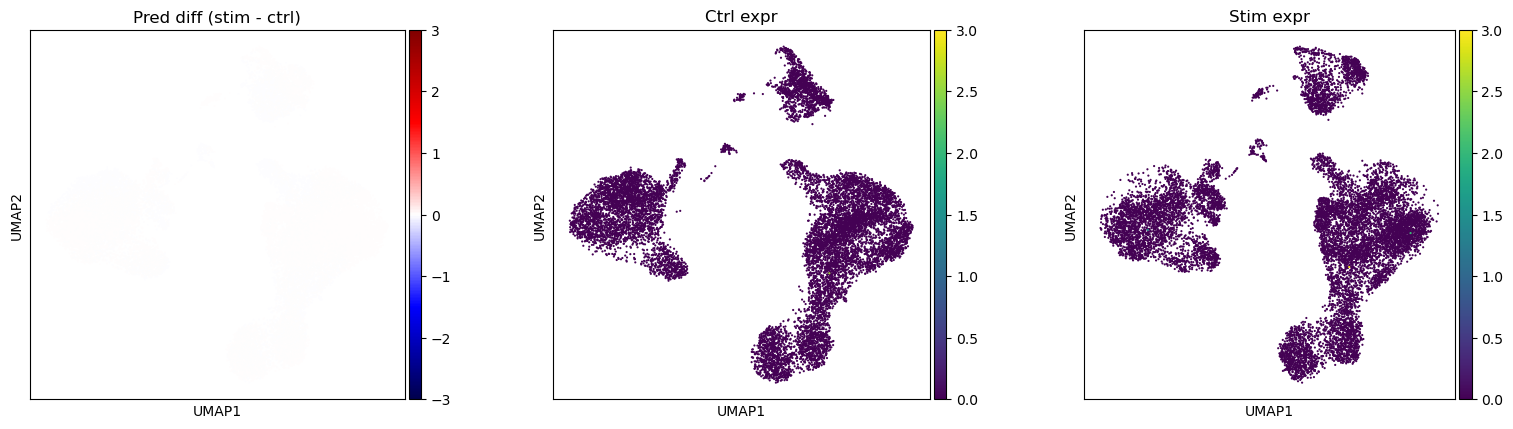

In [39]:
# Also try CXCL10, IL8, and FBXO40
sel_gene = "FBXO40"

fsize = plt.rcParams['figure.figsize']

fig = plt.figure(figsize=(fsize[0] * 3, fsize[1]))

axs = [fig.add_subplot(1, 3, i+1) for i in range(3)]

for ax in axs:
    ax.set_aspect('equal')

sc.pl.umap(
    adata, layer="diff",
    color=[sel_gene], cmap=plt.get_cmap("seismic"), vcenter=0,
    vmin=-3, vmax=3,
    title="Pred diff (stim - ctrl)", ax=axs[0], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "ctrl"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=3,
    title="Ctrl expr", ax=axs[1], show=False
)

sc.pl.umap(
    adata[adata.obs["label"] == "stim"], layer="logcounts",
    color=[sel_gene],
    vmin=0,
    vmax=3,
    title="Stim expr", ax=axs[2]
)

To assess the overall accuracy of LEMUR's predictions, I will compare the average observed and predicted expression per cell type between conditions. The next plot simply shows the observed expression values. Genes on the diagonal don't change expression much between conditions within a cell type, whereas all off-diagonal genes are differentially expressed:

LEMURの予測の全体的な正確さを評価するために、細胞タイプごとの発現の観察値と予測値の平均を条件間で比較してみる。次のプロットは、単純に観察された発現値を示している。対角線上の遺伝子は、同じ細胞タイプでも条件間で発現があまり変化しないのに対し、対角線から外れた遺伝子は全て発現に差がある：

In [40]:
def rowMeans_per_group(X, group):
    uniq = np.unique(group)
    res = np.zeros((len(uniq), X.shape[1]))
    for i, e in enumerate(uniq):
        res[i, :] = X[group == e, :].sum(axis=0) / sum(group == e)
    return res

In [41]:
adata_ctrl = adata[adata.obs["label"] == "ctrl", :].copy()
adata_stim = adata[adata.obs["label"] == "stim", :].copy()

In [42]:
ctrl_expr_per_cell_type = rowMeans_per_group(
    adata_ctrl.layers["logcounts"], adata_ctrl.obs["cell_type"]
)
stim_expr_per_cell_type = rowMeans_per_group(
    adata_stim.layers["logcounts"], adata_stim.obs["cell_type"]
)

In [43]:
ctrl_expr_per_cell_type

array([[2.11106669e-02, 3.78750086e-01, 2.10667938e-01, ...,
        7.02390389e-04, 1.86719105e-03, 1.76093320e-03],
       [2.51967181e-02, 6.92871749e-01, 1.33418851e-02, ...,
        0.00000000e+00, 2.25774013e-03, 1.01160922e-03],
       [2.51934621e-02, 3.77921253e-01, 8.59319940e-02, ...,
        1.41005323e-03, 9.76298354e-04, 4.02354524e-02],
       ...,
       [6.37607798e-02, 1.11237419e+00, 1.45098018e-02, ...,
        0.00000000e+00, 0.00000000e+00, 2.60500261e-03],
       [0.00000000e+00, 1.02293909e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.23379652e-02, 7.24104226e-01, 8.92409086e-01, ...,
        0.00000000e+00, 0.00000000e+00, 2.82446686e-02]])

In [44]:
stim_expr_per_cell_type

array([[1.13878764e-01, 4.26318741e+00, 9.69156697e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.04212320e+00, 6.09374571e+00, 8.85403529e-03, ...,
        0.00000000e+00, 0.00000000e+00, 1.01290666e-03],
       [7.76353404e-02, 3.81049895e+00, 7.08621442e-02, ...,
        8.80977954e-04, 0.00000000e+00, 2.50507239e-02],
       ...,
       [1.22710311e+00, 5.73019266e+00, 4.38950583e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.17554886e-02, 9.09015596e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.27360493e-01, 4.44202757e+00, 6.74322248e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.04637183e-02]])

In [45]:
obs_diff = stim_expr_per_cell_type - ctrl_expr_per_cell_type

In [46]:
obs_diff

array([[ 9.27680973e-02,  3.88443732e+00, -1.13752268e-01, ...,
        -7.02390389e-04, -1.86719105e-03, -1.76093320e-03],
       [ 1.01692648e+00,  5.40087396e+00, -4.48784977e-03, ...,
         0.00000000e+00, -2.25774013e-03,  1.29744876e-06],
       [ 5.24418782e-02,  3.43257770e+00, -1.50698498e-02, ...,
        -5.29075274e-04, -9.76298354e-04, -1.51847284e-02],
       ...,
       [ 1.16334233e+00,  4.61781847e+00, -1.01202959e-02, ...,
         0.00000000e+00,  0.00000000e+00, -2.60500261e-03],
       [ 2.17554886e-02,  8.06721687e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.50225277e-02,  3.71792334e+00, -2.18086839e-01, ...,
         0.00000000e+00,  0.00000000e+00, -1.77809503e-02]])

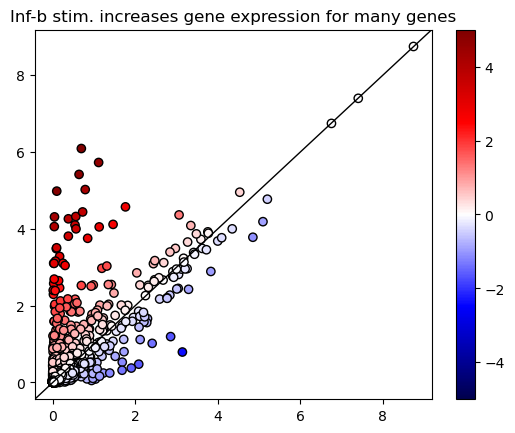

In [47]:
plt.scatter(
    ctrl_expr_per_cell_type, stim_expr_per_cell_type,
    c=obs_diff,
    cmap=plt.get_cmap("seismic"),
    vmin=-5, vmax=5,
    marker="o", edgecolors= "black"
)

plt.colorbar()

plt.title("Inf-b stim. increases gene expression for many genes")

plt.axline((0, 0), (1, 1), linewidth=1, color='black')

plt.show()

To demonstrate that LEMUR learned the underlying expression relations, I predict what the expression of cells from the control condition would have been had they been stimulated and compare the results against the observed expression in the stimulated condition. The closer the points are to the diagonal, the better the predictions.

LEMURが基礎となる発現関係を学習したことを証明するために、コントロール条件の細胞の発現が刺激されていたらどうなっていたかを予測し、その結果を刺激された条件で観察された発現と比較します。点が対角線に近ければ近いほど、予測は優れている。

In [48]:
stim_pred_per_cell_type = rowMeans_per_group(
    stim_pred[adata.obs["label"] == "ctrl"], adata_ctrl.obs["cell_type"]
)

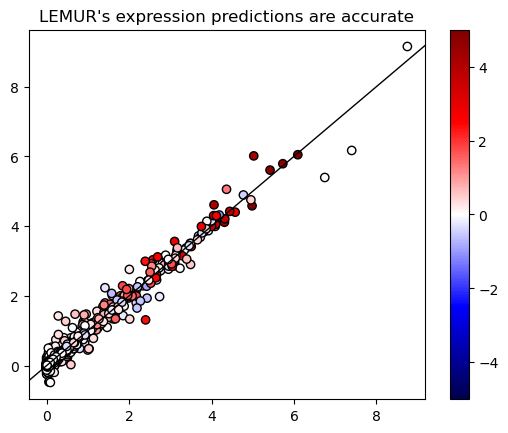

In [49]:
plt.scatter(
    stim_expr_per_cell_type, stim_pred_per_cell_type,
    c=obs_diff,
    cmap=plt.get_cmap("seismic"),
    vmin=-5, vmax=5,
    marker="o", edgecolors="black"
)

plt.colorbar()

plt.title("LEMUR's expression predictions are accurate")

plt.axline((0, 0), (1, 1), linewidth=1, color='black')

plt.show()

Lastly, I directly compare the average predicted differential expression against the average observed differential expression per cell type. Again, the closer the points are to the diagonal, the better the predictions.

最後に、予測された差次 発現の平均値と、細胞タイプごとに観察された差次 発現の平均値とを直接比較する。ここでもポイントが対角線に近ければ近いほど、予測は優れている。

In [50]:
pred_diff = rowMeans_per_group(
    adata.layers["diff"], adata.obs["cell_type"]
)

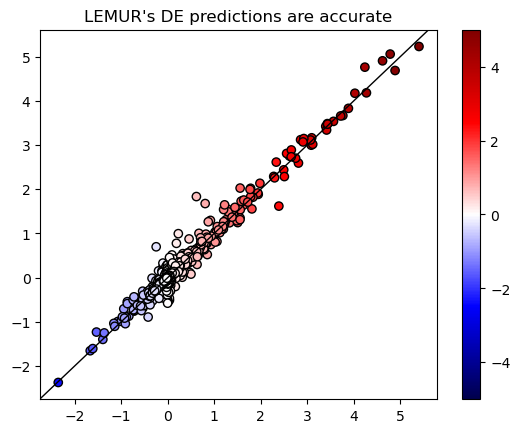

In [51]:
plt.scatter(
    obs_diff, pred_diff,
    c=obs_diff,
    cmap = plt.get_cmap("seismic"),
    vmin=-5, vmax=5,
    marker="o", edgecolors="black"
)

plt.colorbar()

plt.title("LEMUR's DE predictions are accurate")

plt.axline((0, 0), (1, 1), linewidth=1, color='black')

plt.show()

Another advantage of LEMUR's parametricity is that you could train the model on a subset of the data and then apply it to the full data.

I will demonstrate this by training the same LEMUR model on 5% of the original data, then `transform` the full data, and finally compare the first three dimensions of the embedding against the embedding from the model trained on the full model.

LEMURのパラメトリック性のもう1つの利点は、データのサブセットでモデルを訓練し、それを全データに適用できることです。

同じLEMURモデルを元データの5%で訓練し、次に全データを変換し、最後に埋め込みの最初の3次元を、全モデルで訓練したモデルからの埋め込みと比較することで、これを実証します。

In [52]:
adata_subset = adata[
    np.random.choice(
        np.arange(adata.shape[0]),
        size=round(adata.shape[0] * 0.05)
    ),
].copy()

In [53]:
adata_subset

AnnData object with n_obs × n_vars = 1234 × 1000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'label_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'embedding'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'diff'
    obsp: 'distances', 'connectivities'

In [54]:
model_small = pylemur.tl.LEMUR(
    adata_subset,
    design="~ label", n_embedding=15
)

In [55]:
model_small

In [56]:
model_small.fit().align_with_harmony()

Centering the data using linear regression.
Find base point
Fit regression on latent spaces


2024-08-10 17:52:15,443 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-10 17:52:15,616 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-10 17:52:15,621 - harmonypy - INFO - Stopped before convergence


Find shared embedding coordinates
Alignment iteration 0
Alignment iteration 1
Alignment iteration 2
Alignment iteration 3
Converged


In [57]:
emb_proj = model_small.transform(adata)

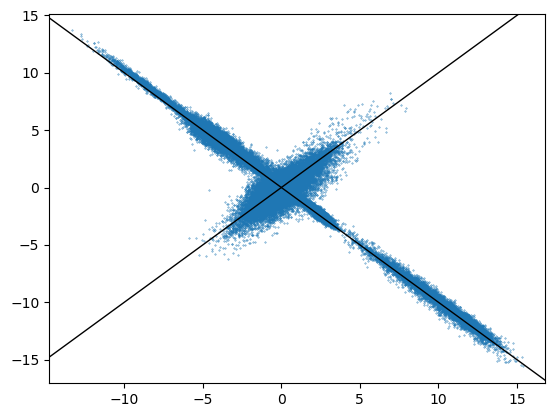

In [58]:
plt.scatter(emb_proj[:, 0:3], model.embedding[:,0:3], s=0.1)

plt.axline((0, 0), (1, 1), linewidth=1, color='black')

plt.axline((0, 0), (-1, 1), linewidth=1, color='black')

plt.show()

We see that the small model still captures most of the relevant variation.

小さなモデルでも、関連する変動のほとんどを捉えていることがわかる。

In [59]:
adata.obsm["embedding_from_small_fit"] = emb_proj

In [60]:
sc.pp.neighbors(adata, use_rep="embedding_from_small_fit")

In [61]:
sc.tl.umap(adata)

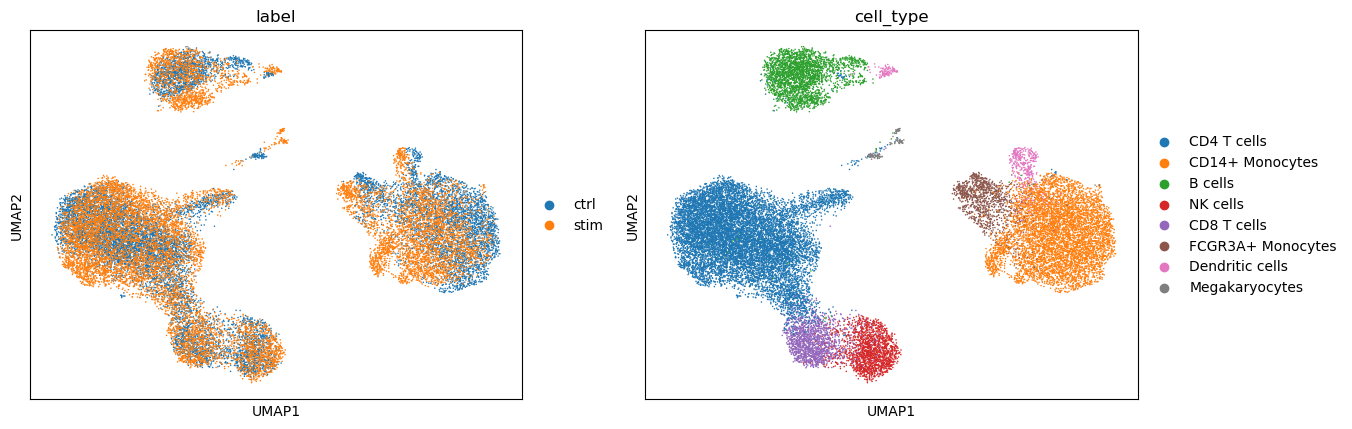

In [62]:
sc.pl.umap(adata, color=["label", "cell_type"])